### 1. Read in the enriched PartB data for year 2013 & 2014

In [25]:
import pandas as pd
import numpy as np
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
parent = os.path.dirname(os.path.dirname(os.getcwd()))

# read in the claim data with year from 2013 to 2014
df = pd.read_csv(parent + '/CMS_datasets/data/year2013_2014_combined_with_labels.csv')

# fill nulls with 0
df.fillna(0, inplace=True)
print(df.shape)
sum(df[df.Fraud_Indicator ==1].groupby('Rndrng_NPI').size()==2)

# assign categorical features to the numeric code for each category
df['Rndrng_Prvdr_Type'] = df['Rndrng_Prvdr_Type'].astype('category').cat.codes
df['Rndrng_Prvdr_Gndr'] = df['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)¶

In [26]:
import random
import cloudpickle
# split out a holdout set for final evaluation, using train_X and train_y for train set evaluation and model tuning
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

char_feat = ['Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr', 'Rndrng_Prvdr_Mdcr_Prtcptg_Ind']
num_feat = list(set(train_X.columns) - set(char_feat))

In [27]:
# Create the function to visulize the confusion matrix
from sklearn.metrics import roc_auc_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)
    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)
    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
#                 fmt='g',
                fmt='d', 
                cmap='Blues',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud']) 
    plt.ylabel('Actual',fontsize=11)
    plt.xlabel('Prediction',fontsize=11)
    plt.title('Holdout set Confusion Matrix', fontsize=13)
    return plt.show()

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc_curve(estimator, test_X, test_y):
    
    y_pred = estimator.predict_proba(test_X)[:, 1]
    roc_auc = roc_auc_score(test_y, y_pred)

    # Get ROC curve data
    fpr, tpr, _ = roc_curve(test_y, y_pred)
    roc_auc_curve = auc(fpr, tpr)

    # Print ROC-AUC score
#     print("ROC-AUC:", roc_auc)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Holdout set Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    return plt.show()

In [29]:
import glob
import cloudpickle
import re
def plot_eval_holdoutset(pat):
    path = parent + '/pyfile/modeling'
    cloudpickle_files = glob.glob(os.path.join(path, f"{pat}*.cloudpickle"))
    cloudpickle_files.sort()
    eval_y = test_y
    eval_X = test_X
    global all_pipe_fitted
    all_pipe_fitted = []
    for cpk in cloudpickle_files:
        if cpk.split('/')[-1].split('.')[0][-1] == '1':
            dsample_rat = '10:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '2':
            dsample_rat = '4:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '3':
            dsample_rat = '2:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '4':
            dsample_rat = '1:1'

        cpkpipe = cloudpickle.load(open(cpk, 'rb'))
        y_pred = cpkpipe.predict(eval_X)
        all_pipe_fitted.append(cpkpipe)
        eval_score0 = roc_auc_score(train_y, cpkpipe.predict_proba(train_X)[:, 1])
        eval_score = roc_auc_score(eval_y, cpkpipe.predict_proba(eval_X)[:, 1])
        plot_roc_auc_curve(cpkpipe, eval_X, eval_y)
        plot_confusion_matrix(cpkpipe, eval_X, eval_y)
        print('Logistic Regression: Undersampling the non-fraud/fraud ratio to', dsample_rat, 
              '\n - Training set roc-auc evaluation score: ', round(eval_score0, 4),
              '\n - Holdout set roc-auc evaluation score: ', round(eval_score, 4))

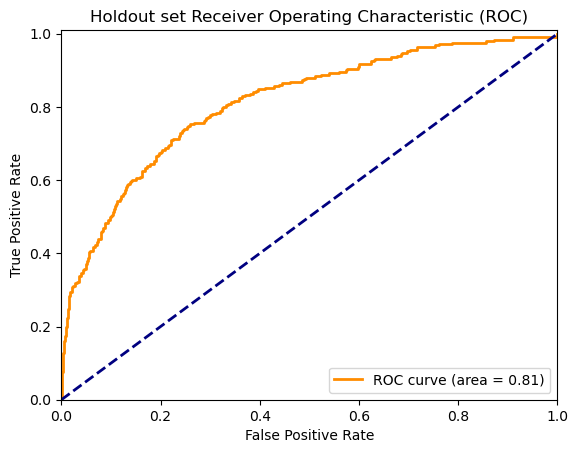

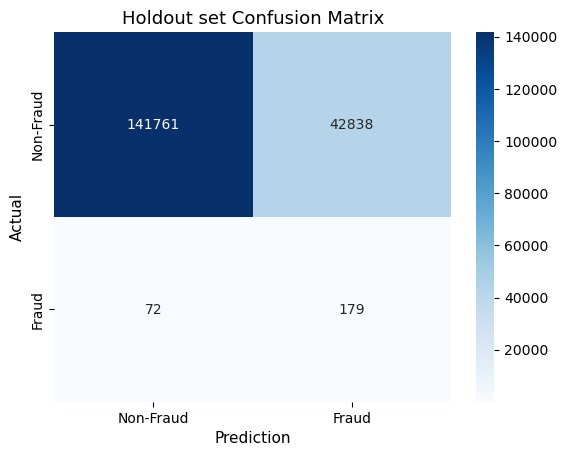

Logistic Regression: Undersampling the non-fraud/fraud ratio to 10:1 
 - Training set roc-auc evaluation score:  0.8529 
 - Holdout set roc-auc evaluation score:  0.8126


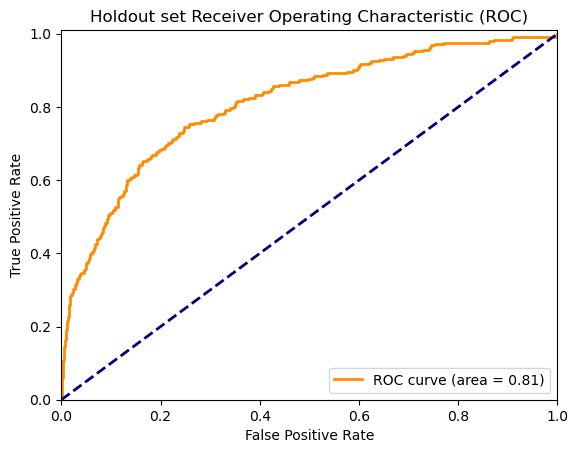

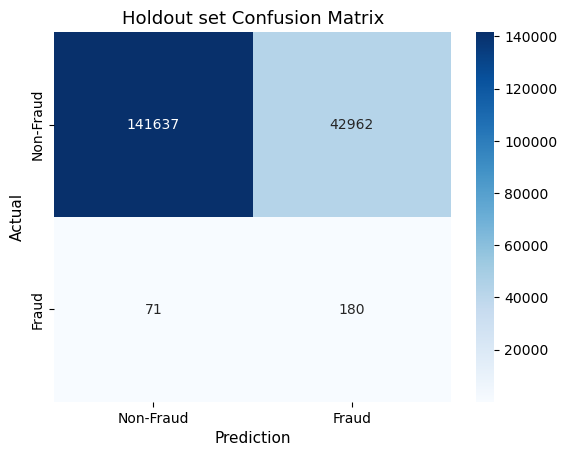

Logistic Regression: Undersampling the non-fraud/fraud ratio to 4:1 
 - Training set roc-auc evaluation score:  0.8531 
 - Holdout set roc-auc evaluation score:  0.8114


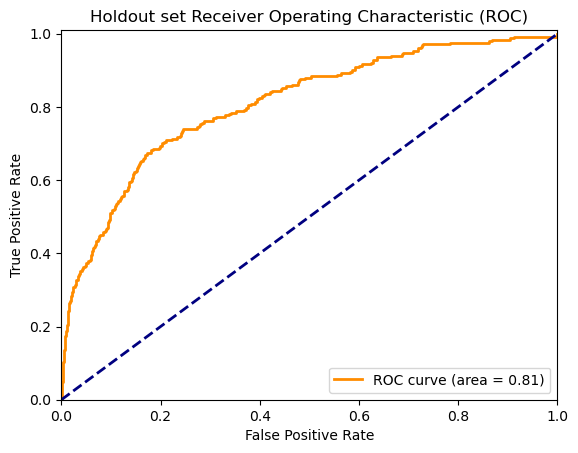

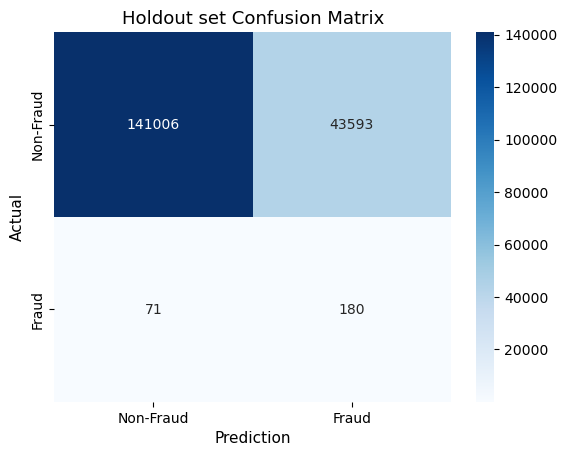

Logistic Regression: Undersampling the non-fraud/fraud ratio to 2:1 
 - Training set roc-auc evaluation score:  0.8518 
 - Holdout set roc-auc evaluation score:  0.81


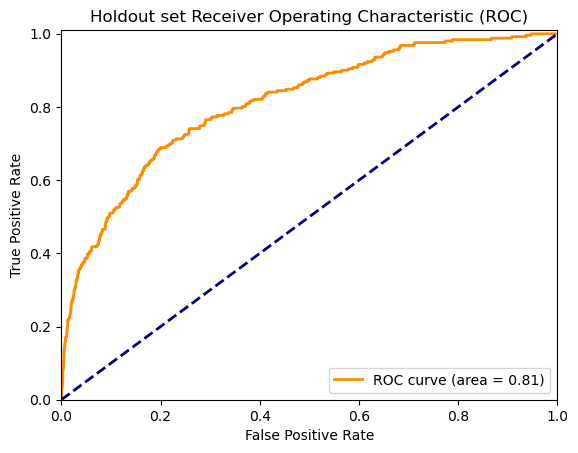

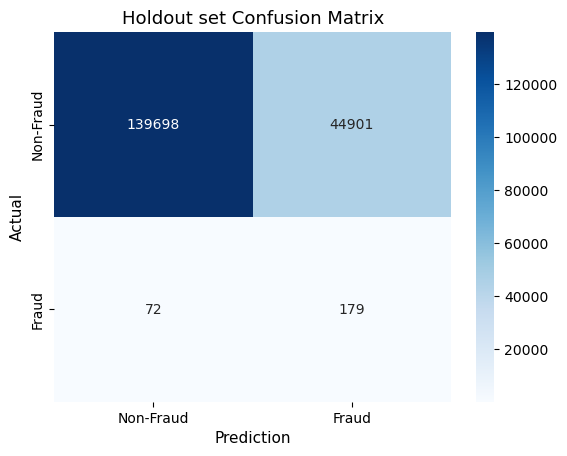

Logistic Regression: Undersampling the non-fraud/fraud ratio to 1:1 
 - Training set roc-auc evaluation score:  0.8455 
 - Holdout set roc-auc evaluation score:  0.8109


In [30]:
# Logistic Regression
plot_eval_holdoutset("lgr_pipe")

In [32]:
all_pipe_fitted[0].named_steps

{'under': RandomUnderSampler(random_state=42, sampling_strategy=0.1),
 'cleaner': ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                  ['Med_Tot_Benes', 'Avg_Mdcr_Stdzd_Amt_mean',
                                   'Tot_Srvcs_median', 'Tot_Bene_Day_Srvcs_std',
                                   'Med_Tot_Srvcs', 'Tot_Benes_max',
                                   'Tot_Srvcs_sum', 'Avg_Mdcr_Stdzd_Amt_median',
                                   'Tot_Benes', 'Tot_Benes_mean',
                                   'Bene_Avg_Risk_Scre', 'Med_Mdcr_Stdzd_Amt',
                                   'Bene_Male_Cnt', 'Bene_CC_Dbts_Pct',
                                   'Bene_CC_Cncr_Pct', 'D...
                                   'Avg_Mdcr_Stdzd_Amt_min', 'Tot_Benes_median',
                                   'Tot_Bene_Day_Srvcs_min',
                                   'Tot_Bene_Day_Srvcs_mean',
                                   'Avg_Mdcr_Stdzd_Amt_std',
   